# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Log</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import time

from typing import Callable, Iterable
from dataclasses import dataclass
from torchvision.transforms import ToTensor

from PIL import Image

# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

from operator import itemgetter
from torch.optim.lr_scheduler import MultiStepLR

In [3]:
class KenyanFood13Dataset(Dataset):
    """
    This custom dataset class takes root directory and train flag, 
    and returns dataset training dataset if train flag is true 
    else it returns validation dataset.
    """
    
    def __init__(self, data_root, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             If it is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transform it.
         
        """
        
        # get label to species mapping
        label_csv_path = os.path.join(data_root, 'train.csv')
        self.data_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        self.classes = self.data_df.iloc[:, 1].unique()
        self.num_classes = len(self.classes)
        self.image_ids = self.data_df.iloc[:, 0]

        self.class_given_label = {image_id : image_class for image_id, image_class in enumerate(self.classes)}
        self.label_given_class = {image_class : image_id for image_id, image_class in enumerate(self.classes)}

        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
                
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform

        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        img_dir = os.path.join(data_root, 'images', 'images')

        # print("self.data_df", type(self.data_df))
        for data in self.data_df.iterrows():
            image_id = str(data[1]['id']) + '.jpg'
            image_path = os.path.join(img_dir, image_id)
            image_class = data[1]['class']
            label = self.label_given_class[image_class]
            self.data_dict['image_path'].append(image_path)
            self.data_dict['label'].append(label)
        
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.image_shape is not None:
            image = F.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
            
        target = self.data_dict['label'][idx]
        
        return image, target            
                
        
    def class_name(self, label):
        """
        class label to common name mapping
        """
        return self.class_given_label[label]

Length of the dataset: 6536
(256, 256)
Label: 4, class name: sukumawiki


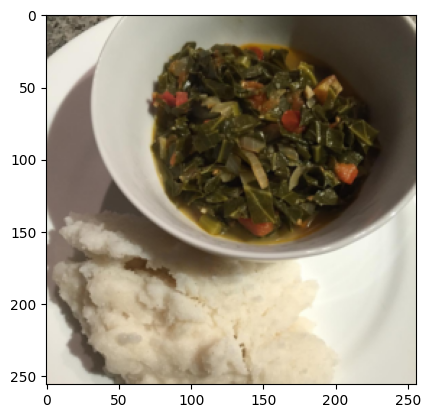

In [4]:
# data root directory
# data_root = '../resource/lib/publicdata/images/10-monkey-species'
data_root = '../../../../data/Week7_project2_classification/KenyanFood13Dataset'

dataset =  KenyanFood13Dataset(data_root, image_shape=256)

print('Length of the dataset: {}'.format(len(dataset)))

img, trgt = dataset[300]
print(img.size)
print('Label: {}, class name: {}'.format(trgt, dataset.class_name(trgt)))
plt.imshow(img)
plt.show()


In [5]:
# def image_preprocess_transforms():
#     preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor()
#         ])
    
#     return preprocess

In [6]:
# def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
#     preprocess = image_preprocess_transforms()
    
#     common_transforms = transforms.Compose([
#         preprocess,
#         transforms.Normalize(mean, std)
#     ])
    
#     return common_transforms
    

In [7]:
# def data_loader(dataset, batch_size=8, shuffle=False, num_workers=2):
#     # dataset = datasets.ImageFolder(root=data_root, transform=transform)

#     # data_subset = torch.utils.data.Subset(dataset,np.arange(0,len(dataset),1./subset_size).astype(int))

#     # loader = torch.utils.data.DataLoader(data_subset, 
#     #                                      batch_size=batch_size,
#     #                                      num_workers=num_workers,
#     #                                      shuffle=shuffle)

#     loader = torch.utils.data.DataLoader(
#         dataset,
#         batch_size=batch_size,
#         shuffle=shuffle,
#         num_workers=num_workers
#     )

#     return loader

In [25]:
class ApplyNormalization():
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Normalize((0., 0., 0.), (0.5, 0.5, 0.5))
        mean, std = self.get_mean_std()
        self.dataset_normalized = transforms.Normalize(mean, std)
        
        print("ApplyNormalization() - self.dataset", type(self.dataset))
        print("ApplyNormalization() - self.dataset_normalized", type(self.dataset_normalized))
        
        test_loader = torch.utils.data.DataLoader(#self.dataset,
                                                  self.dataset_normalized,
                                                  batch_size=15,
                                                  shuffle=True,
                                                  num_workers=2
                                                 )
        print("ApplyNormalization() - self.dataset", type(self.dataset))
        # mean, std = self.get_mean_std()
        # print(mean, std)
        # 

    def get_normalized_dataset(self):
        return self.train_transforms
        
    # def __getitem__(self, index):
    #     x, y = self.dataset[index]
    #     x = self.transform(x)
    #     return x, y

    # def __len__(self):
    #     return len(self.dataset)
            

    def get_mean_std(self):
        mean = [0.485, 0.456, 0.406] 
        std = [0.229, 0.224, 0.225]
        
        return mean, std

    # def get_mean_std(self):
    #     loader = data_loader(dataset=self.dataset, 
    #                          batch_size=8, 
    #                          shuffle=False, 
    #                          num_workers=1)
        
    #     batch_mean = torch.zeros(3)
    #     batch_mean_sqrd = torch.zeros(3)

    #     for batch_data, _ in loader:
    #         batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i] 
    #         batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]
        
    #     # E[dataset] = E[E[batch_1], E[batch_2], ...]
    #     mean = batch_mean / len(loader)
        
    #     # var[X] = E[X**2] - E[X]**2
        
    #     # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    #     # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2
        
    #     var = (batch_mean_sqrd / len(loader)) - (mean ** 2)
            
    #     std = var ** 0.5
    #     print('mean: {}, std: {}'.format(mean, std))
        
    #     return mean, std

In [26]:
# self.train_transforms = transforms.Compose([
#             transforms.RandomChoice([
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomVerticalFlip(),
#                 transforms.RandomRotation(20),
#                 transforms.RandomCrop(28, padding=4),
#                 # transforms.PILToTensor(),
#                 # transforms.ConvertImageDtype(torch.float),
#                 transforms.RandomPerspective(distortion_scale=0.6, p=1),
#                 transforms.ColorJitter(brightness=.5, hue=.3)
#             ]),
#             self.transform
#         ])


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

dataset =  KenyanFood13Dataset(data_root, image_shape=None, transform=preprocess)
print("dataset", type(dataset))

train_size = int(0.8 * len(dataset)) # 80% for training
validation_size = len(dataset) - train_size # 20% for validation

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print("train_dataset", type(train_dataset))

apply_normalization = ApplyNormalization(train_dataset)
# train_dataset_normalized = apply_normalization.get_normalized_dataset()

# print("train_dataset_normalized", type(train_dataset_normalized))

# dataloader with dataset
# test_loader = torch.utils.data.DataLoader(
#         # train_dataset,
#         train_dataset_normalized,
#         batch_size=15,
#         shuffle=True,
#         num_workers=2
#     )
# print("test_loader", type(test_loader))
# # first_batch = next(iter(test_loader))
# # print(first_batch.shape)
# # Plot few images
# plt.rcParams["figure.figsize"] = (15, 9)
# plt.figure
# for images, labels in test_loader:
#     for i in range(len(labels)):
#         plt.subplot(3, 5, i+1)
#         img = F.to_pil_image(images[i])
#         plt.imshow(img)
#         plt.gca().set_title('Target: {0}'.format(labels[i]))
#     plt.show()
#     break

dataset <class '__main__.KenyanFood13Dataset'>
train_dataset <class 'torch.utils.data.dataset.Subset'>
ApplyNormalization() - self.dataset <class 'torch.utils.data.dataset.Subset'>
ApplyNormalization() - self.dataset_normalized <class 'torchvision.transforms.transforms.Normalize'>


TypeError: object of type 'Normalize' has no len()

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-classification-project-2/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

Develop the Interface for the Train Function

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

Main Function

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

## <font style="color:green">8. TensorBoard Log [5 Points]</font>

**Share your TensorBoard scalars logs here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


<font style="color:red">Note:</font> In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**